<a href="https://colab.research.google.com/github/08vivek08/data-science/blob/main/17_Final_Project_Loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
style.use('ggplot')

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-01-01 13:26:05--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-01-01 13:26:06 (180 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
def preprocess(df):
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['effective_date'] = pd.to_datetime(df['effective_date'])
    df['dayofweek'] = df['effective_date'].dt.dayofweek
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
    df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
    df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
    x=df[['Principal','terms','age','Gender','weekend']]
    x=pd.concat([x,pd.get_dummies(df['education'])],axis=1)
    x.drop(['Master or Above'], axis = 1,inplace=True)
#     x= preprocessing.StandardScaler().fit(x).transform(x)
    y= df['loan_status'].values
    return (x,y)
    
x,y=preprocess(df)

In [6]:
x.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [7]:
df['loan_status'].value_counts()

0    260
1     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


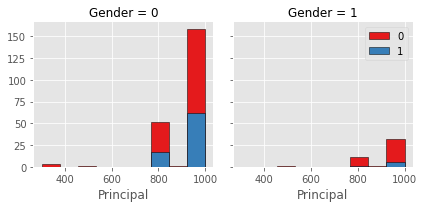

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

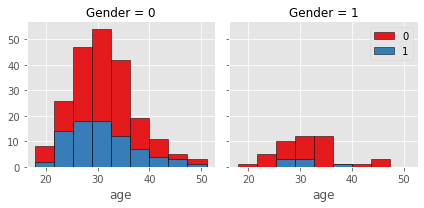

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


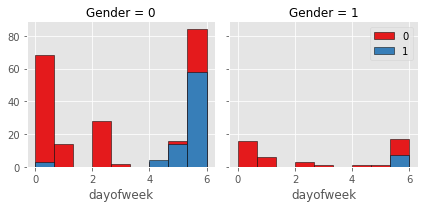

In [10]:
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


## Convert Categorical features to numerical values


Lets look at gender:


In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
0       0              0.731293
        1              0.268707
1       0              0.865385
        1              0.134615
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


## One Hot Encoding

#### How about education?


In [12]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              0              0.750000
                      1              0.250000
High School or Below  0              0.741722
                      1              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               0              0.765101
                      1              0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [13]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [14]:
x= preprocessing.StandardScaler().fit(x).transform(x)
print(x)
print(y)

[[ 0.51578458  0.92071769  2.33152555 ... -0.38170062  1.13639374
  -0.86968108]
 [ 0.51578458  0.92071769  0.34170148 ...  2.61985426 -0.87997669
  -0.86968108]
 [ 0.51578458 -0.95911111 -0.65321055 ... -0.38170062 -0.87997669
   1.14984679]
 ...
 [-1.31458942 -0.95911111  1.33661351 ... -0.38170062 -0.87997669
   1.14984679]
 [ 0.51578458  0.92071769 -0.48739188 ... -0.38170062 -0.87997669
   1.14984679]
 [ 0.51578458  0.92071769 -0.81902922 ... -0.38170062 -0.87997669
   1.14984679]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2)

print('Train set:',x_train.shape,y_train.shape)
print('Test set:',x_test.shape,y_test.shape)
print(y_train)
print(y_test)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)
[0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1
 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0
 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0]
[0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]


In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn import metrics

ks=10
jac_sc=np.zeros((ks-1))
f1_sc=np.zeros((ks-1))
mean_acc=np.zeros((ks-1))

for k in range(1,ks):
    neigh=KNeighborsClassifier(n_neighbors=k).fit(x_train,y_train)
    yhat=neigh.predict(x_test)
    jac_sc[k-1]=jaccard_score(y_test,yhat,labels=None,average='weighted',sample_weight=None)
    f1_sc[k-1]=f1_score(y_test,yhat,average='micro')
    mean_acc[k-1]=metrics.accuracy_score(y_test,yhat)
    
    
print('jaccard score',jac_sc)
print('f1 score',f1_sc)
print('mean accuracy', mean_acc)

jaccard score [0.5349578  0.62144492 0.60045837 0.66596639 0.64780458 0.71445629
 0.63947368 0.66596639 0.59029851]
f1 score [0.64285714 0.74285714 0.71428571 0.78571429 0.75714286 0.82857143
 0.75714286 0.78571429 0.7       ]
mean accuracy [0.64285714 0.74285714 0.71428571 0.78571429 0.75714286 0.82857143
 0.75714286 0.78571429 0.7       ]


In [17]:
print("KNN")
print( "The best jaccard score was with", jac_sc.max(), "with k=", jac_sc.argmax()+1)
print( "The best f1 score was with", f1_sc.max(), "with k=", f1_sc.argmax()+1)
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

KNN
The best jaccard score was with 0.714456289978678 with k= 6
The best f1 score was with 0.8285714285714286 with k= 6
The best accuracy was with 0.8285714285714286 with k= 6


In [18]:
# Finally we model our knn with k=6 for whole train set
neigh=KNeighborsClassifier(n_neighbors=6).fit(x,y)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

# Decision Tree


In [19]:
from sklearn.tree import DecisionTreeClassifier

loanlyTree=DecisionTreeClassifier(criterion="entropy",max_depth=8)
loanlyTree.fit(x_train,y_train)
loanlyTree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [20]:
yhat=loanlyTree.predict(x_test)
jac_sc=jaccard_score(y_test,yhat,labels=None,average='weighted',sample_weight=None)
f1_sc=f1_score(y_test,yhat,average='micro')
mean_acc=metrics.accuracy_score(y_test,yhat)

print("DECISION TREE")
print( "The jaccard score was with", jac_sc)
print( "The f1 score was with", f1_sc)
print( "The accuracy was with", mean_acc)

DECISION TREE
The jaccard score was with 0.6155102040816327
The f1 score was with 0.7428571428571429
The accuracy was with 0.7428571428571429


In [21]:
loanlyTree.fit(x,y)
loanlyTree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Support Vector Machine


In [22]:
from sklearn import svm
clf=svm.SVC(kernel='poly')
clf.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
yhat=clf.predict(x_test)
jac_sc=jaccard_score(y_test,yhat,labels=None,average='weighted',sample_weight=None)
f1_sc=f1_score(y_test,yhat,average='micro')
mean_acc=metrics.accuracy_score(y_test,yhat)

print("SUPPORT VECTOR MACHINE")
print( "The jaccard score was with", jac_sc)
print( "The f1 score was with", f1_sc)
print( "The accuracy was with", mean_acc)

SUPPORT VECTOR MACHINE
The jaccard score was with 0.6628571428571429
The f1 score was with 0.8000000000000002
The accuracy was with 0.8


In [24]:
clf.fit(x,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Logistic Regression


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
LR=LogisticRegression(C=0.01,solver='newton-cg').fit(x_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
yhat=LR.predict(x_test)
jac_sc=jaccard_score(y_test,yhat,labels=None,average='weighted',sample_weight=None)
f1_sc=f1_score(y_test,yhat,average='micro')
log_los=log_loss(y_test,yhat)
mean_acc=metrics.accuracy_score(y_test,yhat)

print("LOGISTIC REGRESSION")
print( "The jaccard score was with", jac_sc)
print( "The f1 score was with", f1_sc)
print( "The log loss was with", log_los)
print( "The accuracy was with", mean_acc)

LOGISTIC REGRESSION
The jaccard score was with 0.686530612244898
The f1 score was with 0.8285714285714286
The log loss was with 5.920933096270403
The accuracy was with 0.8285714285714286


In [27]:
LR=LogisticRegression(C=0.01,solver='newton-cg').fit(x,y)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

# Model Evaluation using Test set


In [28]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [29]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-01-01 13:26:08--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-01-01 13:26:08 (1.00 GB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [30]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [31]:
xtest,ytest=preprocess(test_df)
xtest= preprocessing.StandardScaler().fit(xtest).transform(xtest)
print(xtest)
print(ytest)

[[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]
 [-1.24479571 -0.78854628  0.19650211 -0.50578054  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588 -0.78854628 -1.31937134 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [ 0.49362588  0.92844966  0.02807173 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]
 [-0.66532184 -0.78854628 -0.81408019  1.97714211  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [ 0.49362588 -0.78854628  0.87022365 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.

In [32]:
yhat=neigh.predict(xtest)
jac_sc=jaccard_score(ytest,yhat,labels=None,average='weighted',sample_weight=None)
f1_sc=f1_score(ytest,yhat,average='micro')
mean_acc=metrics.accuracy_score(ytest,yhat)
    
print("KNN with k=6")
print("jaccard score was", jac_sc.max())
print( "The f1 score was ", f1_sc.max())
print( "The accuracy was ", mean_acc.max())

KNN with k=6
jaccard score was 0.6005355846042121
The f1 score was  0.7592592592592593
The accuracy was  0.7592592592592593


In [33]:
yhat=loanlyTree.predict(xtest)
jac_sc=jaccard_score(ytest,yhat,labels=None,average='weighted',sample_weight=None)
f1_sc=f1_score(ytest,yhat,average='micro')
mean_acc=metrics.accuracy_score(ytest,yhat)

print("DECISION TREE")
print( "The jaccard score was with", jac_sc)
print( "The f1 score was with", f1_sc)
print( "The accuracy was with", mean_acc)

DECISION TREE
The jaccard score was with 0.6277777777777778
The f1 score was with 0.7777777777777778
The accuracy was with 0.7777777777777778


In [34]:
yhat=clf.predict(xtest)
jac_sc=jaccard_score(ytest,yhat,labels=None,average='weighted',sample_weight=None)
f1_sc=f1_score(ytest,yhat,average='micro')
mean_acc=metrics.accuracy_score(ytest,yhat)

print("SUPPORT VECTOR MACHINE")
print( "The jaccard score was with", jac_sc)
print( "The f1 score was with", f1_sc)
print( "The accuracy was with", mean_acc)

SUPPORT VECTOR MACHINE
The jaccard score was with 0.5737179487179487
The f1 score was with 0.7407407407407407
The accuracy was with 0.7407407407407407


In [35]:
yhat=LR.predict(xtest)
jac_sc=jaccard_score(ytest,yhat,labels=None,average='weighted',sample_weight=None)
f1_sc=f1_score(ytest,yhat,average='micro')
log_los=log_loss(ytest,yhat)
mean_acc=metrics.accuracy_score(ytest,yhat)

print("LOGISTIC REGRESSION")
print( "The jaccard score was with", jac_sc)
print( "The f1 score was with", f1_sc)
print( "The log loss was with", log_los)
print( "The accuracy was with", mean_acc)

LOGISTIC REGRESSION
The jaccard score was with 0.5486968449931412
The f1 score was with 0.7407407407407407
The log loss was with 8.954497583865733
The accuracy was with 0.7407407407407407


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.601   | 0.759    | NA      |
| Decision Tree      | 0.627   | 0.777    | NA      |
| SVM                | 0.573   | 0.740    | NA      |
| LogisticRegression | 0.548   | 0.740    | 8.954   |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
